#### Magic Commands
Magic commands (those that start with `%`) are commands that modify a configuration of Jupyter Notebooks. A number of magic commands are available by default (see list [here](http://ipython.readthedocs.io/en/stable/interactive/magics.html))--and many more can be added with extensions. The magic command added in this section allows `matplotlib` to display our plots directly on the browser instead of having to save them on a local file.

In [1]:
%matplotlib inline

# Activity 7: Optimizing a deep learning model
In this activity we optimize our deep learning model. We aim achieve greater performance than our model `bitcoin_lstm_v0`, which is off at about **8.4%** from the real Bitcoin prices. We explore the following topics in this notebook:

* Experimenting with different layers and the number of nodes
* Grid search strategy for epoch and activation functions

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [3]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.callbacks import TensorBoard
from keras.layers.core import Dense, Activation, Dropout, ActivityRegularization

D:\Anaconda3\envs\machinelearn\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from scripts.utilities import (create_groups, split_lstm_input, 
                               train_model, plot_two_series, rmse, 
                               mape, denormalize)

In [5]:
plt.style.use('seaborn-white')

In [6]:
np.random.seed(0)

### Load Data
We will load our same train and testing set from previous activitites. 

In [7]:
train = pd.read_csv('data/train_dataset.csv')

In [8]:
test = pd.read_csv('data/test_dataset.csv')

In [9]:
train_data = create_groups(
    train['close_point_relative_normalization'].values)

In [10]:
test_data = create_groups(
    test['close_point_relative_normalization'].values)

In [11]:
X_train, Y_train = split_lstm_input(train_data)

### Reference Model
For reference, let's load data for `v0` of our model and train it alongside future modifications.

In [12]:
model_v0 = load_model('bitcoin_lstm_v0.h5')

In [13]:
%%time
train_model(model=model_v0, X=X_train, Y=Y_train, epochs=100, version=0, run_number=0)

Wall time: 10.2 s


### Adding Layers and Nodes
We can modify our model to include other layers now. When using LSTM cells, one typically adds other LSTM layer in a sequence. In our case the layer will have the same number of neurons as the original layer.

In order for this to work, however, we need to modify the parameter `return_sequences` to `True` on the first LSTM layer. We do this because the first layer expects a sequence of data with the same as input that the of the first layer. When this parameter is set to `False` the LSTM layer outputs the predicted parameters in a different incompatible output.

In [14]:
period_length = 7
number_of_periods = 76
batch_size=1

In [15]:
model_v1 = Sequential()
model_v1.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

model_v1.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

model_v1.add(Dense(units=period_length))
model_v1.add(Activation("linear"))

model_v1.compile(loss="mse", optimizer="rmsprop")

In [16]:
%%time
train_model(model=model_v1, X=X_train, Y=Y_train, epochs=100, version=1, run_number=0)

Wall time: 16.3 s


### Epochs
Epochs are the number of times the network adjust its weights in response to data passing through and its loss function. Running a model for more epochs can allow it to learn more from data, but you also run the risk of overfitting.

When training a model, prefer to increase the epochs exponentially until the loss function starts to plateau. In the case of the `bitcoin_lstm_v0` model, its loss function plateaus at about 100 epochs. If one attempts to train it at 10^3 epochs, the model barely gains any improvements.

In [17]:
#
#  Change the number of epochs below
#  to a higher number (try 10**3) and
#  evaluate the results on TensorBoard.
#
number_of_epochs = 10**3

In [18]:
model_v2 = Sequential()
model_v2.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

model_v2.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

model_v2.add(Dense(units=period_length))
model_v2.add(Activation("linear"))

model_v2.compile(loss="mse", optimizer="rmsprop")

In [19]:
%%time
train_model(model=model_v2, X=X_train, Y=Y_train, epochs=number_of_epochs, 
            version=2, run_number=0)

Wall time: 1min 46s


### Activation Functions
Due to its non-linear properties and efficient computation, we will use the `relu` function as this network's activation function. 

In [20]:
#
#  Instead of using a ReLU, visit
#  the Keras official documentation (https://keras.io/activations/)
#  and choose a different function to try (maybe "tanh").
#
activation_function = "tanh"

In [21]:
model_v3 = Sequential()
model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

model_v3.add(Dense(units=period_length))
model_v3.add(Activation(activation_function))

model_v3.compile(loss="mse", optimizer="rmsprop")

In [22]:
%%time
train_model(model=model_v3, X=X_train, Y=Y_train, epochs=300, 
            version=3, run_number=0)

Wall time: 37.9 s


### Regularization Strategies
In this section we implement a `Dropout()` regularization strategy.

In [23]:
model_v4 = Sequential()
model_v4.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

#
#  Implement a Dropout() here.
#
Dropout(0.4)
model_v4.add(Dropout(0.4))
model_v4.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

#
#  Implement a Dropout() here too.
#
Dropout(0.4)
model_v4.add(Dropout(0.4))
model_v4.add(Dense(units=period_length))
model_v4.add(Activation(activation_function))

model_v4.compile(loss="mse", optimizer="rmsprop")

In [24]:
%%time
train_model(model=model_v4, X=X_train, Y=Y_train, epochs=600, 
            version=3, run_number=0)

Wall time: 1min 6s


## Evaluate Models
After creating the model versions above, we now have to evaluate which model is performing best in our test data. In order to do that we will use three metrics: MSE, RMSE, and MAPE. MSE is used to compare the error rates of the model on each predicted week. RMSE and MAPE are computed for making the model results easier to interpret.

In [25]:
combined_set = np.concatenate((train_data, test_data), axis=1)

In [26]:
def evaluate_model(model, kind='series'):
    """
    Uses Keras model.evaluate() method to compute
    the MSE for all future weeks in period.
    
    Parameters
    ----------
    model: Keras trained model
    
    kind: str, default 'series'
        Kind of evaluation to perform. If 'series', 
        then the model will perform an evaluation 
        over the complete series.
    
    Returns
    -------
    evaluated_weeks: list
        List of MSE values for each evaluated
        test week.
    """
    if kind == 'series':
        predicted_weeks = []
        for i in range(0, test_data.shape[1]):
            input_series = combined_set[0:,i:i+76]
            predicted_weeks.append(model.predict(input_series))

        predicted_days = []
        for week in predicted_weeks:
            predicted_days += list(week[0])

        return predicted_days
    else:
        evaluated_weeks = []
        for i in range(0, test_data.shape[1]):
            input_series = combined_set[0:,i:i+77]

            X_test = input_series[0:,:-1].reshape(1, input_series.shape[1] - 1, 7)
            Y_test = input_series[0:,-1:][0]

            result = model.evaluate(x=X_test, y=Y_test, verbose=0)
            evaluated_weeks.append(result)
            
            return evaluated_weeks


In [27]:
def plot_weekly_mse(series, model_name, color):
    ax = pd.Series(series).plot(drawstyle="steps-post",
                                figsize=(14,4),
                                linewidth=2,
                                color=color,
                                grid=True,
                                label=model_name,
                                alpha=0.7,
                                title='Mean Squared Error (MSE) for Test Data (all models)'.format(
                                       model_name))

    y = [i for i in range(0, len(series))]
    yint = range(min(y), math.ceil(max(y))+1)
    plt.xticks(yint)

    ax.set_xlabel("Predicted Week")
    ax.set_ylabel("MSE")
    
    return ax

Let's plot the weekly MSE.

In [28]:
def plot_weekly_predictions(predicted_days, name, display_plot=True, 
                            variable='close'):
    
    combined = pd.concat([train, test])
    
    last_day = datetime.strptime(train['date'].max(), '%Y-%m-%d')
    list_of_days = []
    for days in range(1, len(predicted_days) + 1):
        D = (last_day + timedelta(days=days)).strftime('%Y-%m-%d')
        list_of_days.append(D)
    
    predicted = pd.DataFrame({
        'date': list_of_days, 
        'close_point_relative_normalization': predicted_days 
    })
    
    combined['date'] = combined['date'].apply(
                    lambda x: datetime.strptime(x, '%Y-%m-%d'))
    
    predicted['date'] = predicted['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    
    observed = combined[combined['date'] > train['date'].max()]
    
    predicted['iso_week'] = predicted['date'].apply(
                            lambda x: x.strftime('%Y-%U'))
    
    predicted_close = predicted.groupby('iso_week').apply(
                            lambda x: denormalize(observed, x))
    
    plot_two_series(observed, predicted_close, 
                    variable=variable,
                    title='{}: Predictions per Week'.format(name))
    
    print('RMSE: {:.4f}'.format(
        rmse(observed[variable][:-3], 
             predicted_close[variable])))

    print('MAPE: {:.1f}%'.format(
        mape(observed[variable][:-3], 
             predicted_close[variable])))

Finally, let's evaluate each one the models trained in this activity in sequence. 

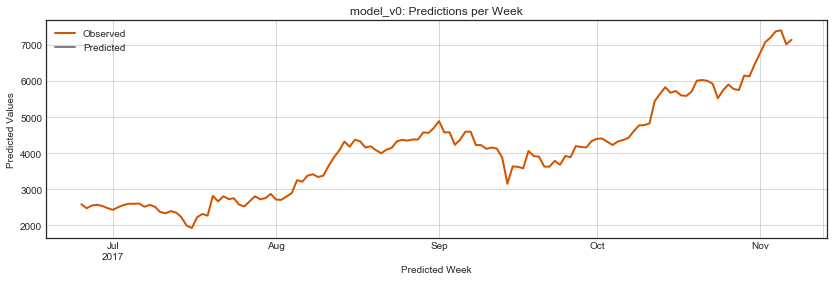

RMSE: 1875.6950
MAPE: 0.0%


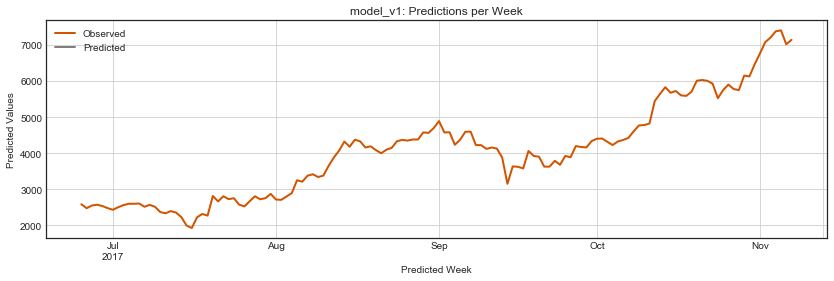

RMSE: 1875.7003
MAPE: 0.0%


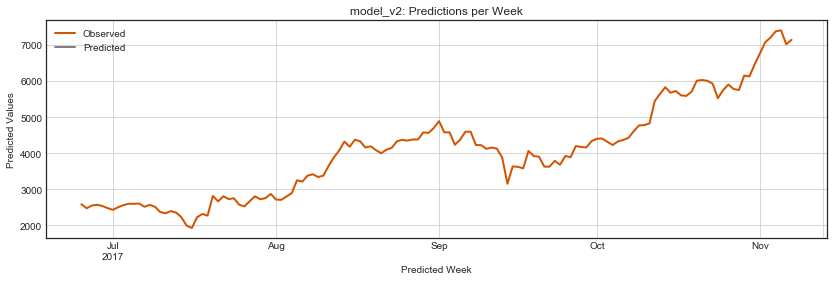

RMSE: 1875.7041
MAPE: 0.0%


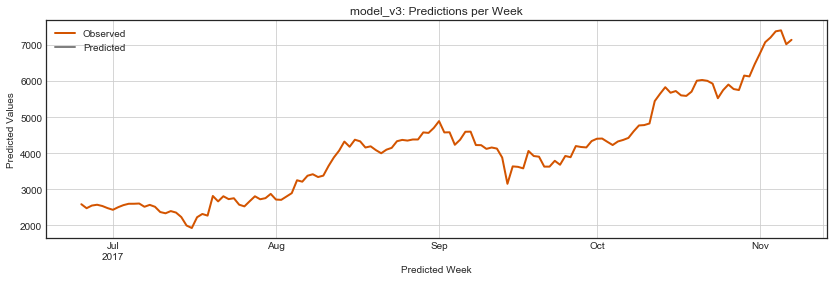

RMSE: 1875.6935
MAPE: 0.0%


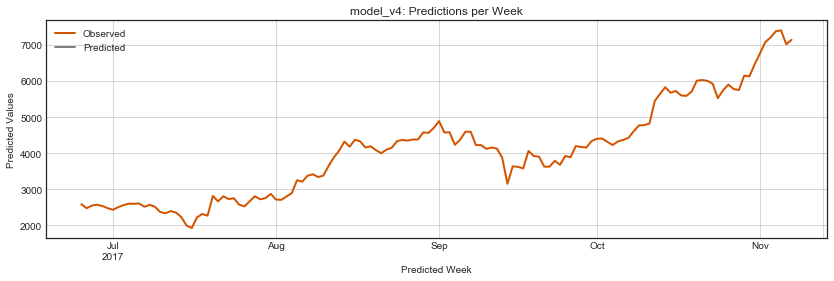

RMSE: 1875.7058
MAPE: 0.0%


In [29]:
models = [model_v0, model_v1, model_v2, model_v3, model_v4]
for i, M in enumerate(models):
    predicted_days = evaluate_model(M, kind='other')
    plot_weekly_predictions(predicted_days, 'model_v{}'.format(i), display_plot=False)

Our first model outperformed all the other models. Take the opportunity and teak the values for the optimization techniques above and attempt to beat the performance of that model!